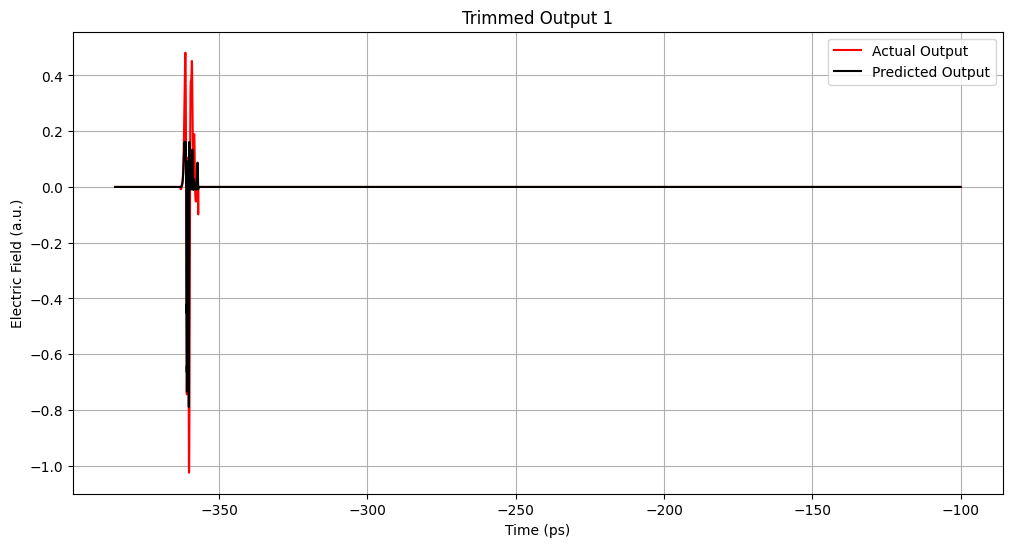

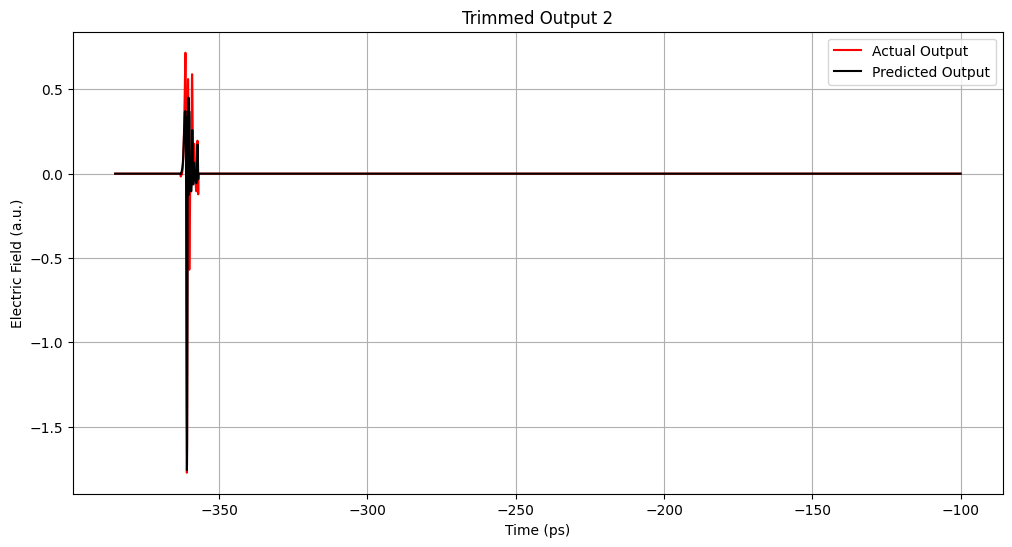

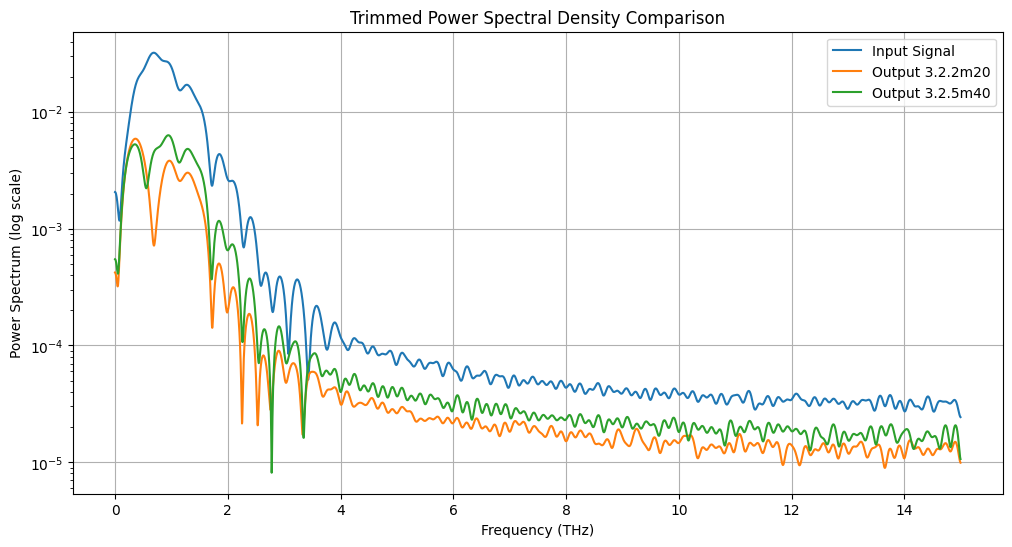

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, fftfreq

def manual_load_data(filename):
    times = []
    fields = []
    with open(filename, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith('#'):
                continue
            parts = line.replace(',', ' ').split()
            if len(parts) >= 2:
                try:
                    times.append(float(parts[0]))
                    fields.append(float(parts[1]))
                except ValueError:
                    continue
    return pd.DataFrame({'Time (ps)': times, 'Electric Field (a.u.)': fields})


input_data_1 = manual_load_data('1.2.txt')
input_data_2 = manual_load_data('3.2.0.txt')
output_data_1 = manual_load_data('3.2.2m20.txt')
output_data_2 = manual_load_data('3.2.5m40.txt')

def trim_signal(time, signal, start=-363, end=-357):
    return np.where((time >= start) & (time <= end), signal, 0)


def calculate_power_spectrum(time, signal):
    N = len(signal)
    dt = time[1] - time[0]
    yf = fft(signal)
    xf = fftfreq(N, dt)[:N//2]
    power = 2/N * np.abs(yf[:N//2])
    return xf, power

def create_features(E, n):
    return np.column_stack([E**i for i in range(1, n+1)])

def train_model(input_data, output_data, n):
    X = create_features(input_data['Electric Field (a.u.)'].values, n)
    y = output_data['Electric Field (a.u.)'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    return model, mse, y_pred


n_values = [2, 5, 10]
models = {}

for n in n_values:
    m1, mse1, pred1 = train_model(input_data_1, output_data_1, n)
    models[f'n={n}_output1'] = {'model': m1, 'mse': mse1, 'pred': pred1}
    m2, mse2, pred2 = train_model(input_data_1, output_data_2, n)
    models[f'n={n}_output2'] = {'model': m2, 'mse': mse2, 'pred': pred2}


def plot_trimmed_comparison(input_data, output_data, model_info, n, title):
    t = input_data['Time (ps)'].values
    E = input_data['Electric Field (a.u.)'].values
    X = create_features(E, n)
    y_pred = model_info['model'].predict(X)
    trimmed_actual = trim_signal(t, output_data['Electric Field (a.u.)'].values)
    trimmed_pred = trim_signal(t, y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(t, trimmed_actual, label='Actual Output', color='red')
    plt.plot(t, trimmed_pred, label='Predicted Output', color='black')
    plt.xlabel('Time (ps)')
    plt.ylabel('Electric Field (a.u.)')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

best_n1 = min(n_values, key=lambda x: models[f'n={x}_output1']['mse'])
best_n2 = min(n_values, key=lambda x: models[f'n={x}_output2']['mse'])

plot_trimmed_comparison(input_data_1, output_data_1, models[f'n={best_n1}_output1'], best_n1, 'Trimmed Output 1')
plot_trimmed_comparison(input_data_1, output_data_2, models[f'n={best_n2}_output2'], best_n2, 'Trimmed Output 2')


xf_input, power_input = calculate_power_spectrum(
    input_data_1['Time (ps)'].values,
    trim_signal(input_data_1['Time (ps)'].values, input_data_1['Electric Field (a.u.)'].values)
)
xf_output1, power_output1 = calculate_power_spectrum(
    output_data_1['Time (ps)'].values,
    trim_signal(output_data_1['Time (ps)'].values, output_data_1['Electric Field (a.u.)'].values)
)
xf_output2, power_output2 = calculate_power_spectrum(
    output_data_2['Time (ps)'].values,
    trim_signal(output_data_2['Time (ps)'].values, output_data_2['Electric Field (a.u.)'].values)
)

plt.figure(figsize=(12, 6))
plt.semilogy(xf_input, power_input, label='Input Signal')
plt.semilogy(xf_output1, power_output1, label='Output 3.2.2m20')
plt.semilogy(xf_output2, power_output2, label='Output 3.2.5m40')
plt.xlabel('Frequency (THz)')
plt.ylabel('Power Spectrum (log scale)')
plt.title('Trimmed Power Spectral Density Comparison')
plt.legend()
plt.grid()
plt.show()


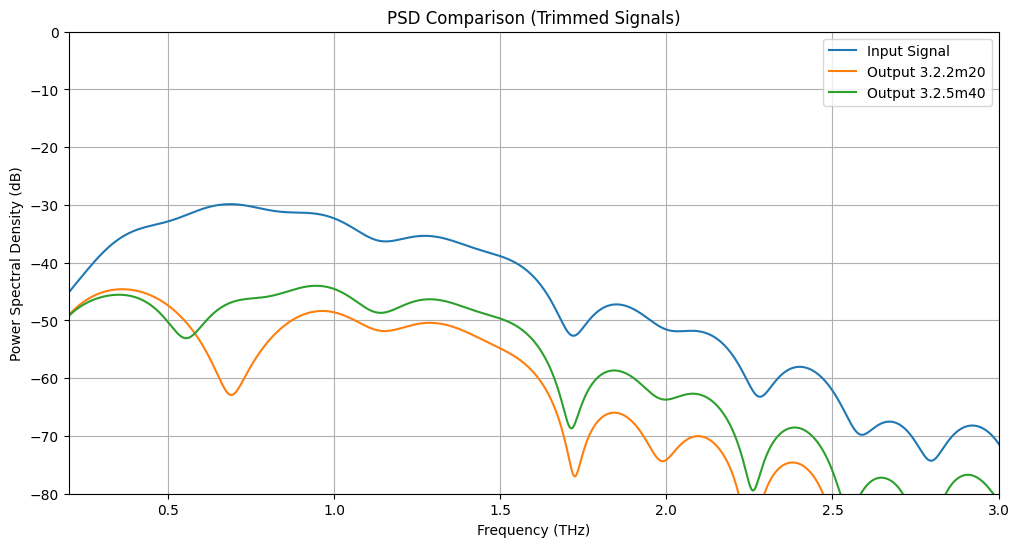

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def trim_signal_in_time(time, signal, t_min=-363, t_max=-357):
    return np.where((time >= t_min) & (time <= t_max), signal, 0)

def calculate_power_spectrum_dB(time, signal):
    N = len(signal)
    dt = time[1] - time[0]
    yf = fft(signal)
    xf = fftfreq(N, dt)[:N//2]
    power_linear = (2.0 / N) * np.abs(yf[:N//2])
    power_dB = 20 * np.log10(power_linear + 1e-12)  # avoid log(0)
    return xf, power_dB


trimmed_input = trim_signal_in_time(input_data_1['Time (ps)'].values,
                                     input_data_1['Electric Field (a.u.)'].values)
trimmed_output1 = trim_signal_in_time(output_data_1['Time (ps)'].values,
                                      output_data_1['Electric Field (a.u.)'].values)
trimmed_output2 = trim_signal_in_time(output_data_2['Time (ps)'].values,
                                      output_data_2['Electric Field (a.u.)'].values)

xf_input, psd_input = calculate_power_spectrum_dB(input_data_1['Time (ps)'].values, trimmed_input)
xf_output1, psd_output1 = calculate_power_spectrum_dB(output_data_1['Time (ps)'].values, trimmed_output1)
xf_output2, psd_output2 = calculate_power_spectrum_dB(output_data_2['Time (ps)'].values, trimmed_output2)

# --- PSD Plot ---
plt.figure(figsize=(12, 6))
plt.plot(xf_input, psd_input, label='Input Signal')
plt.plot(xf_output1, psd_output1, label='Output 3.2.2m20')
plt.plot(xf_output2, psd_output2, label='Output 3.2.5m40')
plt.xlim(0.2, 3)             # Frequency range (THz)
plt.ylim(-80, 0)             # Power in dB
plt.xlabel('Frequency (THz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD Comparison (Trimmed Signals)')
plt.grid(True)
plt.legend()
plt.show()


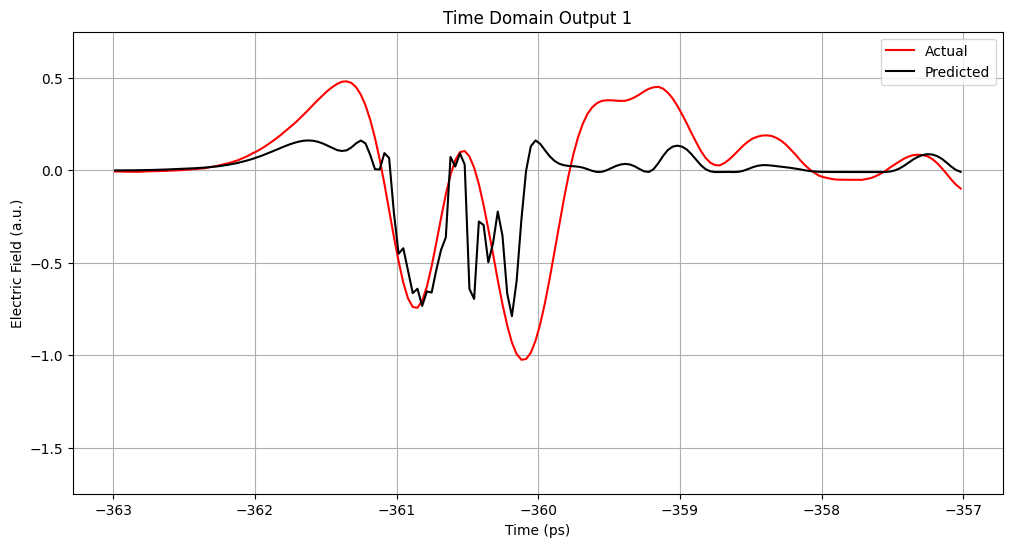

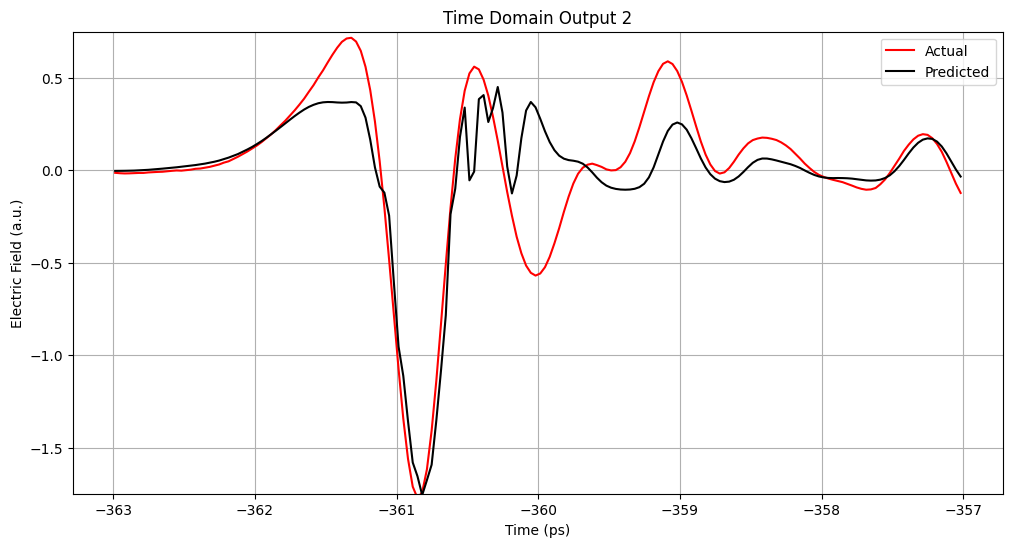

In [15]:
def plot_time_trimmed_output(input_data, output_data, model_info, n, title):
    t = input_data['Time (ps)'].values
    E = input_data['Electric Field (a.u.)'].values
    X = np.column_stack([E**i for i in range(1, n+1)])
    y_pred = model_info['model'].predict(X)
    mask = (t >= -363) & (t <= -357)
    t_trim = t[mask]
    y_actual_trim = output_data['Electric Field (a.u.)'].values[mask]
    y_pred_trim = y_pred[mask]
    plt.figure(figsize=(12, 6))
    plt.plot(t_trim, y_actual_trim, label='Actual', color='red')
    plt.plot(t_trim, y_pred_trim, label='Predicted', color='black')
    plt.ylim(-1.75, 0.75)
    plt.xlabel('Time (ps)')
    plt.ylabel('Electric Field (a.u.)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
plot_time_trimmed_output(input_data_1, output_data_1, models[f'n={best_n1}_output1'], best_n1, 'Time Domain Output 1')
plot_time_trimmed_output(input_data_1, output_data_2, models[f'n={best_n2}_output2'], best_n2, 'Time Domain Output 2')


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def create_features(E, n):
    """Create polynomial features E, E^2, ..., E^n"""
    return np.column_stack([E**i for i in range(1, n+1)])
def train_model_no_scaling(input_data, output_data, n):
    X = create_features(input_data['Electric Field (a.u.)'].values, n)
    y = output_data['Electric Field (a.u.)'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    print(f"Model trained with n={n}, MSE = {mse:.6f}")
    return model, mse

In [19]:
n_values = [2, 5, 10]
models = {}
for n in n_values:
    model1, mse1 = train_model_no_scaling(input_data_1, output_data_1, n)
    models[f'n={n}_output1'] = {'model': model1, 'mse': mse1}
    model2, mse2 = train_model_no_scaling(input_data_1, output_data_2, n)
    models[f'n={n}_output2'] = {'model': model2, 'mse': mse2}

Model trained with n=2, MSE = 0.001970
Model trained with n=2, MSE = 0.001465
Model trained with n=5, MSE = 0.001882
Model trained with n=5, MSE = 0.001401
Model trained with n=10, MSE = 0.001643
Model trained with n=10, MSE = 0.001228


In [20]:
def print_coefficients(model_info, n):
    model = model_info['model']
    print(f"\nCoefficients for n={n}:")
    print(f"Intercept (m): {model.intercept_:.6f}")
    for i, coef in enumerate(model.coef_, 1):
        print(f"a{i}: {coef:.6f}")
for n in n_values:
    print_coefficients(models[f'n={n}_output1'], n)
    print_coefficients(models[f'n={n}_output2'], n)



Coefficients for n=2:
Intercept (m): 0.001745
a1: -0.011706
a2: -0.013926

Coefficients for n=2:
Intercept (m): 0.001249
a1: 0.136104
a2: -0.010460

Coefficients for n=5:
Intercept (m): 0.001888
a1: 0.057779
a2: -0.035404
a3: -0.005096
a4: 0.000654
a5: 0.000099

Coefficients for n=5:
Intercept (m): 0.001238
a1: 0.198218
a2: -0.021221
a3: -0.004409
a4: 0.000214
a5: 0.000058

Coefficients for n=10:
Intercept (m): 0.000584
a1: 0.073115
a2: 0.128939
a3: -0.022537
a4: -0.038445
a5: -0.001807
a6: 0.002579
a7: 0.000335
a8: -0.000042
a9: -0.000010
a10: -0.000000

Coefficients for n=10:
Intercept (m): 0.000146
a1: 0.215685
a2: 0.114681
a3: -0.021824
a4: -0.031635
a5: -0.001181
a6: 0.002087
a7: 0.000259
a8: -0.000034
a9: -0.000008
a10: -0.000000
